# Investment Performance Tracker

This notebook tracks the performance of investment decisions stored in the `stock_tracker.db` / `subscribers.db` database.
It fetches historical price data using `yfinance` and calculates the Return on Investment (ROI) for various decision categories (e.g., STRONG BUY, BUY, SELL).

## Updates
- **Recovery Analysis**: Calculates how long (in days) it took for the stock to recover to its pre-drop price.
- **Outlier Removal**: Excludes data points with ROI > 100% to keep visualizations readable.

In [1]:
# Install necessary libraries if not already installed
# !pip install yfinance pandas matplotlib seaborn

In [2]:
import sqlite3
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import os

# Configuration
DB_PATH = "../subscribers.db"  # Adjust path if running from notebooks/ dir
if not os.path.exists(DB_PATH):
    # Fallback to absolute path or check current dir
    DB_PATH = "subscribers.db"
    if not os.path.exists(DB_PATH):
        # Try determining path relative to this notebook
        DB_PATH = os.path.join(os.getcwd(), "..", "subscribers.db")

print(f"Using Database: {DB_PATH}")

Using Database: ../subscribers.db


## 1. Load Data from Database

In [3]:
def load_decisions(db_path):
    conn = sqlite3.connect(db_path)
    query = """
    SELECT 
        id, symbol, price_at_decision, drop_percent, recommendation, 
        reasoning, status, timestamp, ai_score, 
        deep_research_verdict, deep_research_score
    FROM decision_points
    ORDER BY timestamp ASC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

df = load_decisions(DB_PATH)

# Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# Filter out test symbols
df = df[~df['symbol'].isin(['MOCK_TEST', 'TEST', 'EXAMPLE', 'XYZ'])]

# Standardize Recommendation
df['recommendation'] = df['recommendation'].str.upper().str.strip()

# Calculate Pre-Drop Price
# Price At Decision = PreDrop * (1 + drop_percent/100)
# PreDrop = Price At Decision / (1 + drop_percent/100)
df['pre_drop_price'] = df['price_at_decision'] / (1 + (df['drop_percent'] / 100))

# Display Summary
print(f"Loaded {len(df)} decisions.")
print("Columns:", df.columns.tolist())
df.head()

Loaded 943 decisions.
Columns: ['id', 'symbol', 'price_at_decision', 'drop_percent', 'recommendation', 'reasoning', 'status', 'timestamp', 'ai_score', 'deep_research_verdict', 'deep_research_score', 'date', 'pre_drop_price']


,id,symbol,price_at_decision,drop_percent,recommendation,reasoning,status,timestamp,ai_score,deep_research_verdict,deep_research_score,date,pre_drop_price
0,176,SYM,60.48,-17.399618,0.0,*** EXECUTIVE SUMMARY ***\nI am issuing an imm...,Not Owned,2025-12-05 11:49:39,NaN,None,NaN,2025-12-05,73.22
1,177,SNOW,234.77,-11.407547,0.0,*** EXECUTIVE SUMMARY ***\nI am vetoing any lo...,Not Owned,2025-12-05 11:52:14,NaN,None,NaN,2025-12-05,265.00
2,178,TBVPF,0.34,-8.108108,0.0,*** EXECUTIVE SUMMARY ***\nThe investment comm...,Not Owned,2025-12-05 11:54:31,NaN,None,NaN,2025-12-05,0.37
3,179,LYB,43.16,-6.235064,0.0,*** EXECUTIVE SUMMARY ***\nI am issuing an imm...,Not Owned,2025-12-05 11:56:58,NaN,None,NaN,2025-12-05,46.03
4,180,MEDP,544.77,-5.502264,ANALYZING,Gemini is analyzing this stock...,Pending,2025-12-05 11:59:06,NaN,None,NaN,2025-12-05,576.49


## 2. Fetch Historical Data, Calculate ROI & Recovery

We will fetch daily close prices for each stock from the decision date to today.
We also assume "Recovery" means returning to the `Pre-Drop Price`.

In [43]:
ticker = yf.Ticker('AAPL')
# Fetch slightly before to ensure coverage, but mainly from start_date
# yfinance expects string 'YYYY-MM-DD'
#start_str = start_date.strftime('%Y-%m-%d')
hist = ticker.history(start='2026-01-13')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-01-13 00:00:00-05:00,258.720001,261.809998,258.390015,261.049988,45730800,0.0,0.0
2026-01-14 00:00:00-05:00,259.489990,261.820007,256.709991,259.959991,40019400,0.0,0.0
2026-01-15 00:00:00-05:00,260.649994,261.040009,257.049988,258.209991,39388600,0.0,0.0
2026-01-16 00:00:00-05:00,257.899994,258.899994,254.929993,255.529999,72018600,0.0,0.0


In [4]:
def get_ticker_history(symbol, start_date):
    """
    Fetches daily history for a symbol from start_date to now.
    Returns a Series of Close prices indexed by Date.
    """
    try:
        ticker = yf.Ticker(symbol)
        # Fetch slightly before to ensure coverage, but mainly from start_date
        # yfinance expects string 'YYYY-MM-DD'
        start_str = start_date.strftime('%Y-%m-%d')
        hist = ticker.history(start=start_str)
        return hist['Close']
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return pd.Series()

# Cache to avoid refetching same symbol multiple times if multiple decisions exist
price_cache = {}

def calculate_performance(row):
    symbol = row['symbol']
    start_date = row['date']
    start_price = row['price_at_decision']
    target_recovery_price = row['pre_drop_price']
    
    # Unique Key for cache: Symbol + StartDate
    if symbol not in price_cache:
        price_cache[symbol] = get_ticker_history(symbol, start_date)
    
    hist = price_cache[symbol]
    
    if hist.empty:
        return None
        
    hist = hist[hist.index.date >= start_date]
    
    if hist.empty:
        return None

    latest_price = hist.iloc[-1]
    roi = ((latest_price - start_price) / start_price) * 100
    
    # Calculate Days to Recover
    days_to_recover = np.nan
    recovered = False
    
    # Find first day where price >= target_recovery_price
    # Note: price_at_decision might be lower than pre_drop_price if drop_percent is negative.
    # If drop_percent was positive (price went up?), logic holds inverse.
    # Assuming drop_percent is e.g. -10.0
    
    check_recovery = hist[hist >= target_recovery_price]
    if not check_recovery.empty:
        recovery_date = check_recovery.index[0].date()
        days_to_recover = (recovery_date - start_date).days
        recovered = True
    
    return {
        'current_price': latest_price,
        'roi_percent': roi,
        'days_held': (datetime.now().date() - start_date).days,
        'days_to_recover': days_to_recover,
        'recovered': recovered
    }

print("Fetching price data... (This may take a moment)")

# Iterate and Calculate
for index, row in df.iterrows():
    perf = calculate_performance(row)
    if perf:
        df.at[index, 'current_price'] = perf['current_price']
        df.at[index, 'roi_percent'] = perf['roi_percent']
        df.at[index, 'days_held'] = perf['days_held']
        df.at[index, 'days_to_recover'] = perf['days_to_recover']
        df.at[index, 'recovered'] = perf['recovered']
    else:
        df.at[index, 'current_price'] = np.nan
        df.at[index, 'roi_percent'] = np.nan

print("Done.")
# Drop rows where data couldn't be fetched
df_clean = df.dropna(subset=['roi_percent']).copy()

Fetching price data... (This may take a moment)


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 002402"}}}
$002402: possibly delisted; no timezone found
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 4704"}}}
$4704: possibly delisted; no timezone found
$0TCP: possibly delisted; no timezone found
$A40PU6: possibly delisted; no timezone found
$0RPY: possibly delisted; no timezone found
$SREN: possibly delisted; no price data found  (1d 2025-12-05 -> 2026-01-17)
$300979: possibly delisted; no timezone found
$0QL6: possibly delisted; no timezone found
$688775: possibly delisted; no timezone found
$BOOZT: possibly delisted; no timezone found
$601872: possibly delisted; no timezone found
$A2PMY9: possibly delisted; no timezone found
$1B2: possibly delisted; no timezone found
$A3EH8Z: possibly delisted; no timezone found
$MOTV3F: possibly delisted; no timezone found
$BOOZT_DKK: possibly delisted; no t

Done.


## 3. Filtering & Outlier Removal

1. Filter Data by Deep Research Verdict: `None`, `WAIT_FOR_STABILIZATION`, `SPECULATIVE_BUY`, `HARD_AVOID`, `STRONG_BUY`
2. Remove Outliers: Exclude entries with ROI greater than 100%.

In [6]:
df_clean.shape

(470, 18)

In [38]:
df_clean.days_to_recover

0      38.0
1       NaN
2       4.0
3      32.0
4      31.0
       ... 
938     NaN
939     NaN
940     NaN
941     NaN
942     NaN
Name: days_to_recover, Length: 470, dtype: float64

In [7]:
# 1. Deep Research Filter
valid_verdicts = [None, 'WAIT_FOR_STABILIZATION', 'SPECULATIVE_BUY', 'HARD_AVOID', 'STRONG_BUY']
mask_verdict = df_clean['deep_research_verdict'].isin(valid_verdicts) | df_clean['deep_research_verdict'].isna()
df_clean = df_clean[mask_verdict].copy()

# 2. Outlier Removal (ROI > 100%)
original_count = len(df_clean)
df_clean = df_clean[df_clean['roi_percent'] <= 100]
pruned_count = original_count - len(df_clean)

print(f"Filtered Data Count: {len(df_clean)} (Pruned {pruned_count} outliers > 100% ROI)")

Filtered Data Count: 470 (Pruned 0 outliers > 100% ROI)


## 4. Recovery Analysis

How long does it take for stocks to recover to their pre-drop price?

In [17]:
df_clean_recommended = df_clean[df_clean.recommendation.isin(['HOLD', 'SPECULATIVE BUY','BUY', 'SELL', 'STRONG SELL', 'STRONG BUY'])]

In [45]:
pd.crosstab(df_clean_recommended['deep_research_verdict'], df_clean_recommended['recovered'])

recovered,False,True
deep_research_verdict,,
HARD_AVOID,6,0
SPECULATIVE_BUY,15,17
STRONG_BUY,3,0
WAIT_FOR_STABILIZATION,45,39


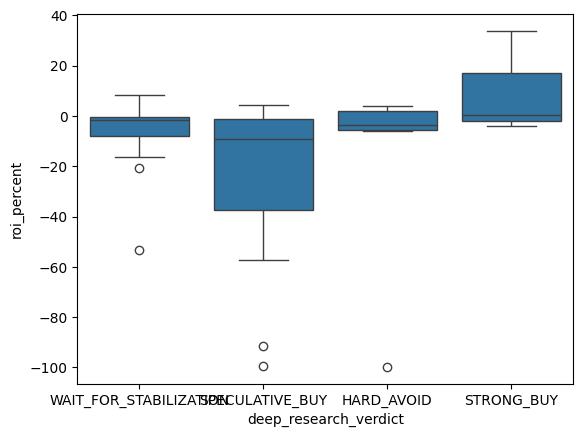

In [25]:
# Filter for items that have actually recovered
df_not_recovered = df_clean_recommended[df_clean_recommended['recovered'] == 0]


sns.boxplot(x='deep_research_verdict', y='roi_percent', data=df_not_recovered)
plt.show()


Stocks Recovered: 178 / 470 (37.9%)
Average Days to Recover: 12.8
Median Days to Recover: 10.0


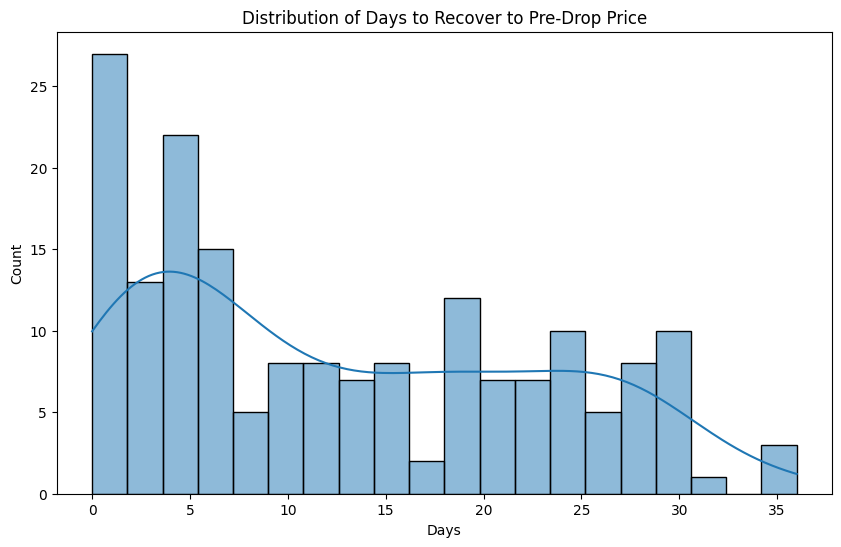

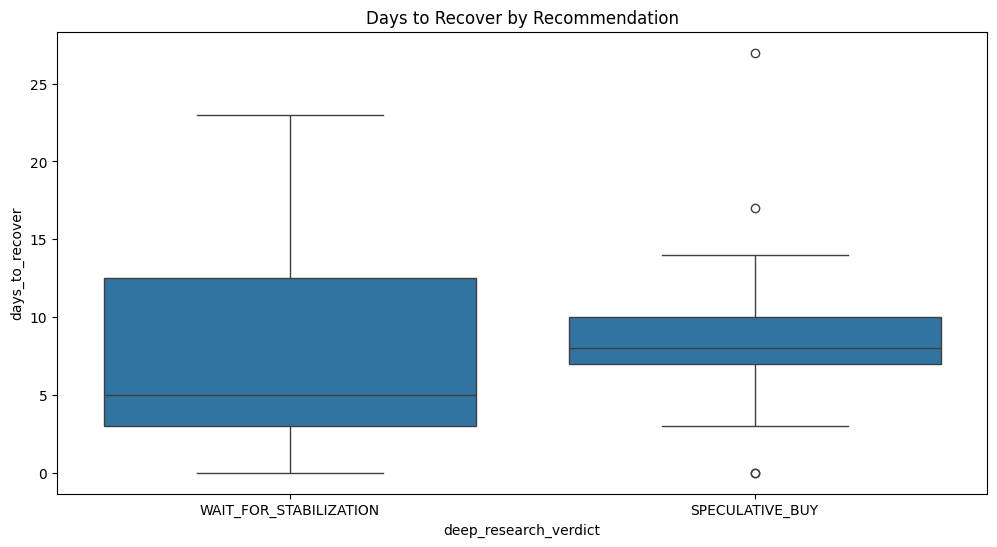

In [30]:
# Filter for items that have actually recovered
df_recovered = df_clean_recommended[df_clean_recommended['recovered'] == 1]

if not df_recovered.empty:
    print(f"Stocks Recovered: {len(df_recovered)} / {len(df_clean)} ({len(df_recovered)/len(df_clean)*100:.1f}%)")
    
    avg_days = df_recovered['days_to_recover'].mean()
    median_days = df_recovered['days_to_recover'].median()
    print(f"Average Days to Recover: {avg_days:.1f}")
    print(f"Median Days to Recover: {median_days:.1f}")

    # Histogram of Recovery Days
    plt.figure(figsize=(10, 6))
    sns.histplot(df_recovered['days_to_recover'], bins=20, kde=True)
    plt.title('Distribution of Days to Recover to Pre-Drop Price')
    plt.xlabel('Days')
    plt.ylabel('Count')
    plt.show()
    
    # Recover Days by Recommendation
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='deep_research_verdict', y='days_to_recover', data=df_recovered)
    plt.title('Days to Recover by Recommendation')
    plt.show()
else:
    print("No stocks in this filtered set have recovered yet.")

## 5. Performance by Recommendation (Cleaned)


                        count       mean    median        min        max
deep_research_verdict                                                   
HARD_AVOID                  6 -17.581971 -3.692743 -99.722119   3.904281
SPECULATIVE_BUY            32  -4.188228  3.401472 -99.380952  41.935490
STRONG_BUY                  3  10.054401  0.455021  -4.121858  33.830039
WAIT_FOR_STABILIZATION     84   2.535839 -0.134591 -53.494912  53.656539


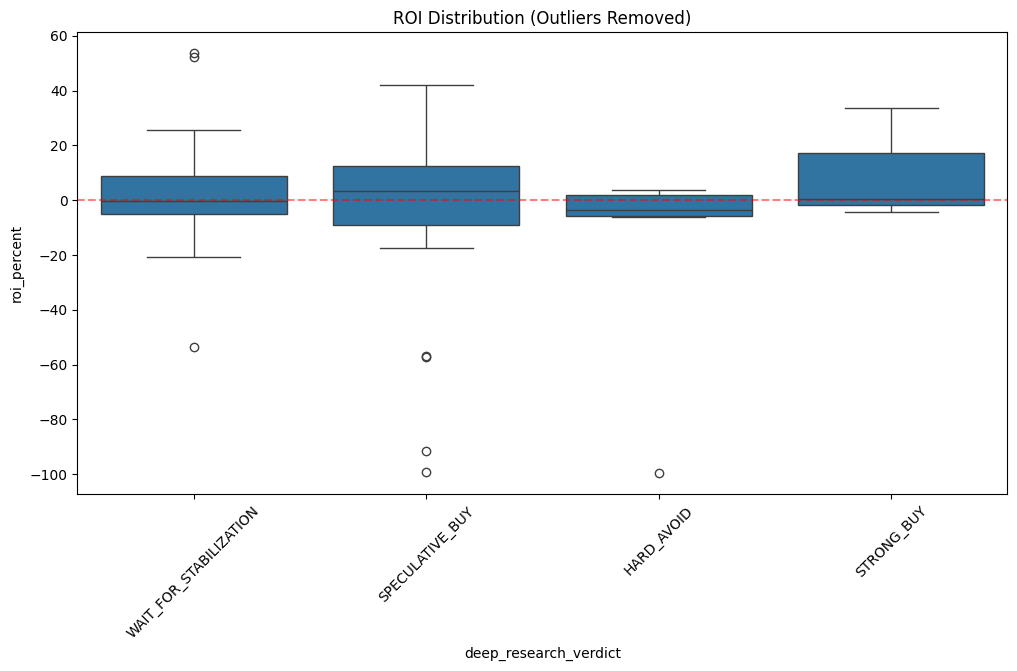

In [31]:
summary = df_clean_recommended.groupby('deep_research_verdict')['roi_percent'].agg(['count', 'mean', 'median', 'min', 'max'])
print(summary)

plt.figure(figsize=(12, 6))
sns.boxplot(x='deep_research_verdict', y='roi_percent', data=df_clean_recommended)
plt.title('ROI Distribution (Outliers Removed)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

## 6. Scoring vs Performance

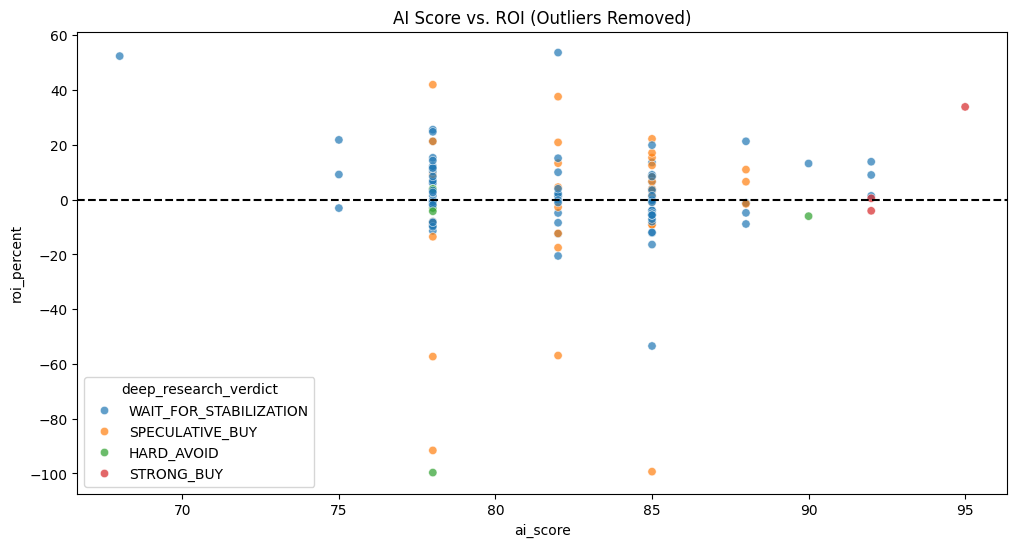

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ai_score', y='roi_percent', hue='deep_research_verdict', data=df_clean_recommended, alpha=0.7)
plt.title('AI Score vs. ROI (Outliers Removed)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

## 7. Performance Over Time

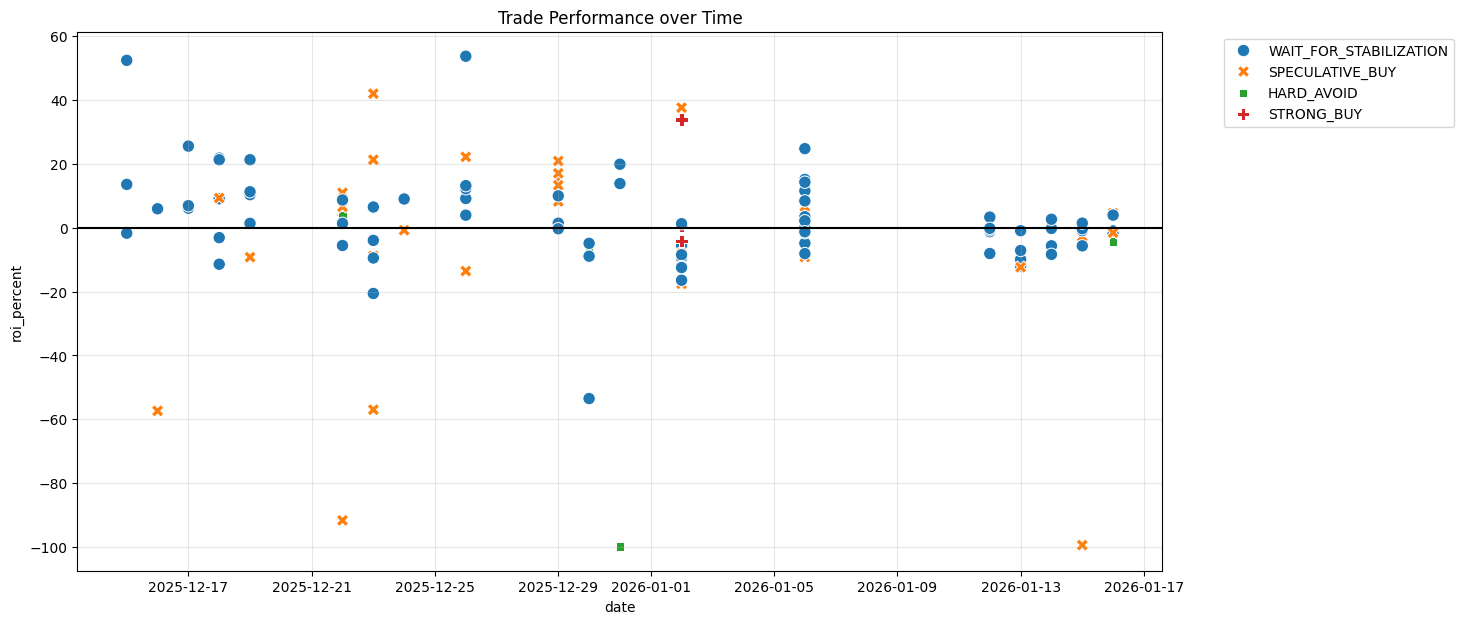

In [33]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='date', y='roi_percent', hue='deep_research_verdict', data=df_clean_recommended, style='deep_research_verdict', s=80)
plt.title('Trade Performance over Time')
plt.axhline(0, color='black', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
df_clean_recommended.groupby('deep_research_verdict').roi_percent.agg(['count', 'mean', 'median', 'min', 'max'])

,count,mean,median,min,max
deep_research_verdict,,,,,
HARD_AVOID,6,-17.581971,-3.692743,-99.722119,3.904281
SPECULATIVE_BUY,32,-4.188228,3.401472,-99.380952,41.935490
STRONG_BUY,3,10.054401,0.455021,-4.121858,33.830039
WAIT_FOR_STABILIZATION,84,2.535839,-0.134591,-53.494912,53.656539
